In [1]:
import time
import warnings

warnings.filterwarnings("ignore")


from functools import reduce

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns

# from lazypredict.Supervised import LazyRegressor

plt.style.use("ggplot")
%matplotlib inline


import optuna
from optuna.integration import CatBoostPruningCallback, LightGBMPruningCallback

optuna.logging.set_verbosity(optuna.logging.WARNING)

import plotly.express as px
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor, plot_importance
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, RepeatedKFold, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OrdinalEncoder, RobustScaler
from xgboost import DMatrix, XGBRegressor

## Reading the data

In [2]:
train = pd.read_csv("Train.csv", parse_dates=["RECORD_DATE"]).rename(columns=str.lower)
test = pd.read_csv("Test.csv", parse_dates=["RECORD_DATE"]).rename(columns=str.lower)
emp = pd.read_csv("employment_status.csv").rename(columns=str.lower)
ss = pd.read_csv("SampleSubmission.csv").rename(columns=str.lower)
income = pd.read_csv("income_group.csv").rename(columns=str.lower)
customer = pd.read_csv("customer.csv", parse_dates=["DATE_LAST_UPDATED"]).rename(
    columns=str.lower
)
trans = pd.read_csv("transactions.csv", parse_dates=["RECORD_DATE"]).rename(
    columns=str.lower
)

## Data Analysis

In [3]:
train.head()

,customer_identifier,record_date,declared_net_income
0,ID_18018255686b76dbc534d0edf0f7b4e9bb6cc3cde15...,2022-07-01,"13,500"
1,ID_782a96eb5b14b4cedc7df05389c6e4751c087026513...,2022-04-01,"9,000"
2,ID_fbf3035c5b8e7da652269551c78d634a48bca823076...,2022-06-01,"8,000"
3,ID_a0081832892639d933929e24ce46203ea417e17ecbe...,2022-08-01,"7,000"
4,ID_86ee557b2a4506ac40331d40370a40e37e0b95b9f23...,2022-07-01,"10,400"


In [4]:
test.head()

,customer_identifier,record_date
0,ID_005e5c1206b2d9857432a381df19989353c3e1b6b0d...,2022-06-01
1,ID_c28fb2d93c7b4be50a57aa7ebbe31a6bae33a18e1c6...,2022-01-01
2,ID_94bbc5ce0228e1d25179755dacdf9fc7359a5bbc74a...,2022-05-01
3,ID_41ccd69246cea3c1b4d9349f21d7af2dd092cf7eed4...,2022-05-01
4,ID_09e29a91e9369a11075b1fd7fd209f3a0c96fb18432...,2022-03-01


In [5]:
income.head()

,income_group_code,income_group_desc
0,0,NOT SUPPLIED
1,1,R 0 - 499
2,2,R500 - 999
3,3,"R1,000 - 1,999"
4,4,"R2,000 - 2,999"


In [6]:
emp.head()

,employee_status_code,employee_status_desc
0,0,Resigned
1,3,Active
2,1,Inactive
3,2,Retiree


In [7]:
customer.head()

,customer_identifier,date_last_updated,sex_code,income_group_code,number_of_accounts,occupational_status_code,age
0,ID_00a7d65f82a6819e79c29a84e805777f0265308b655...,2022-09-01,1,6,4,7,51
1,ID_09651edcac6c55a5e401062b0c0ef7bbba3f3e49538...,2022-09-01,0,7,10,3,32
2,ID_17215674e76eb33b47c4dd3ac3392e3e8f1a34b131b...,2022-09-01,1,7,7,1,41
3,ID_212860dd16c79ea8eae97cc1fc181e6afd4862fceaf...,2022-09-01,0,13,10,1,44
4,ID_24953f74da44bd0915c4cb78c1d97cbbd66e85bbd91...,2022-08-01,0,13,6,1,44


In [8]:
trans.head()

,transaction_description,customer_identifier,record_date,account_type_code,account_balance,amt,event_number,product_code,channel,account_number,transaction_reference
0,NaN,ID_017ba29a4d371608fad8313ff1d46c8bb42ef830ee0...,2022-07-13 00:00:00+02:00,9317537c2329262b5e19d3e29d23422558e519ca8ff0a8...,1857.56,1000.00,11785,SAVE,internet,89fe98c0e6ccddcf9a0368507f02773693e01dfeb6911c...,NaN
1,NaN,ID_017ba29a4d371608fad8313ff1d46c8bb42ef830ee0...,2022-02-26 00:00:00+02:00,9317537c2329262b5e19d3e29d23422558e519ca8ff0a8...,8843.46,-2000.00,11348,SAVE,internet,89fe98c0e6ccddcf9a0368507f02773693e01dfeb6911c...,NaN
2,POS PURCHASE,ID_017ba29a4d371608fad8313ff1d46c8bb42ef830ee0...,2022-07-26 00:00:00+02:00,e92177da406abc0e0a5bce83e853dbdb4e792af521a0ae...,23.82,-199.98,148,CHEQ,system,89fe98c0e6ccddcf9a0368507f02773693e01dfeb6911c...,04ae923a903fb07b5c846eb61eda25c4766800f02c2e09...
3,NaN,ID_017ba29a4d371608fad8313ff1d46c8bb42ef830ee0...,2022-03-27 00:00:00+02:00,9317537c2329262b5e19d3e29d23422558e519ca8ff0a8...,198.11,-79.39,11419,SAVE,system,89fe98c0e6ccddcf9a0368507f02773693e01dfeb6911c...,NaN
4,NaN,ID_017ba29a4d371608fad8313ff1d46c8bb42ef830ee0...,2022-05-06 00:00:00+02:00,9317537c2329262b5e19d3e29d23422558e519ca8ff0a8...,13631.60,-200.00,11528,SAVE,atm,89fe98c0e6ccddcf9a0368507f02773693e01dfeb6911c...,NaN


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entries, 0 to 3599
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   customer_identifier  3600 non-null   object        
 1   record_date          3600 non-null   datetime64[ns]
 2   declared_net_income  3600 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 84.5+ KB


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1544 entries, 0 to 1543
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   customer_identifier  1544 non-null   object        
 1   record_date          1544 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 24.2+ KB


In [11]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5144 entries, 0 to 5143
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   customer_identifier       5144 non-null   object        
 1   date_last_updated         5144 non-null   datetime64[ns]
 2   sex_code                  5144 non-null   int64         
 3   income_group_code         5144 non-null   int64         
 4   number_of_accounts        5144 non-null   int64         
 5   occupational_status_code  5144 non-null   int64         
 6   age                       5144 non-null   int64         
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 281.4+ KB


In [12]:
income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   income_group_code  22 non-null     int64 
 1   income_group_desc  22 non-null     object
dtypes: int64(1), object(1)
memory usage: 480.0+ bytes


In [13]:
emp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   employee_status_code  4 non-null      int64 
 1   employee_status_desc  4 non-null      object
dtypes: int64(1), object(1)
memory usage: 192.0+ bytes


In [14]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847544 entries, 0 to 847543
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype                                
---  ------                   --------------   -----                                
 0   transaction_description  475339 non-null  object                               
 1   customer_identifier      847544 non-null  object                               
 2   record_date              847544 non-null  datetime64[ns, pytz.FixedOffset(120)]
 3   account_type_code        847544 non-null  object                               
 4   account_balance          847544 non-null  float64                              
 5   amt                      847544 non-null  float64                              
 6   event_number             847544 non-null  int64                                
 7   product_code             847544 non-null  object                               
 8   channel                  847544 no

In [15]:
# customer.merge(transaction, how='inner', on='customer_identifier').drop(columns=['transaction_description', 'transaction_reference'], axis=1)

In [16]:
## Let's combine data set to perform preprocessing
df_train = train.copy()
df_test = test.copy()

df_customer = customer.copy()
df_trans = trans.copy()

## Preprocessing

In [17]:
def preprocess_data(df_train, df_test, df_customer, df_trans):
    # Changing the dtype of target variable to float
    df_train["declared_net_income"] = (
        df_train["declared_net_income"]
        .str.replace(",", "")
        .astype("float64", errors="ignore")
    )

    ## Preprocessing df_trans dataset

    # Encoding categorical columns with few categories
    df_trans["product_code"] = df_trans["product_code"].map({"SAVE": 1, "CHEQ": 2})

    df_trans["channel"] = df_trans["channel"].map(
        {"internet": 1, "system": 2, "atm": 3, "teller": 4}
    )

    # Extracting day value from datateime column
    df_trans["record_date_day"] = df_trans["record_date"].dt.day
    df_trans["trans_record_date_month"] = df_trans["record_date"].dt.month

    df_trans["account_type_code"] = OrdinalEncoder().fit_transform(
        df_trans[["account_type_code"]]
    )
    # df_trans["transaction_description"] = OrdinalEncoder().fit_transform(df_trans[["transaction_description"]])

    # Dropping large categorical columns
    df_trans.drop(
        columns=[
            "account_number",
            "transaction_reference",
            "transaction_description",
            "record_date",
        ],
        axis=1,
        inplace=True,
    )

    ## Preprocessing df_train, df_test and df_customer data

    # As year and day value are same for "record_date" feature
    # Extracting month from datetime column
    df_train["record_date_month"] = df_train["record_date"].dt.month
    df_test["record_date_month"] = df_test["record_date"].dt.month

    # Dropping the columns "record_date"
    df_train.drop(columns="record_date", inplace=True)
    df_test.drop(columns="record_date", inplace=True)

    # Extracting month vlaue from "date_last_updated_month" column
    df_customer["date_last_updated_month"] = df_customer["date_last_updated"].dt.month
    # Dropping the column
    df_customer.drop(columns="date_last_updated", inplace=True)

    ## Merging Dataframes

    # Merging df_customer to df_trans
    trans_customer = df_customer.merge(df_trans, on="customer_identifier", how="inner")

    # Merging df_train and df_test with trans_customer
    df_train = df_train.merge(trans_customer, on="customer_identifier", how="inner")
    df_test = df_test.merge(trans_customer, on="customer_identifier", how="inner")

    # Removing duplicates
    df_train.drop_duplicates("customer_identifier", inplace=True)
    df_test.drop_duplicates("customer_identifier", inplace=True)

    return df_train, df_test, df_customer, df_trans

In [18]:
df_train, df_test, df_customer, df_trains = preprocess_data(
    df_train, df_test, df_customer, df_trans
)

## Machine Learning

In [19]:
# Separating features and target
features = df_train.drop(
    columns=["customer_identifier", "declared_net_income", "sex_code", "product_code"],
    axis=1,
)
target = df_train[["declared_net_income"]].values

# Creating training and validation data
X_train = df_train.loc[df_train["record_date_month"] < 8].drop(
    columns="customer_identifier"
)  # Using data of months less than 8 for training
X_val = df_train.loc[df_train["record_date_month"] == 8].drop(
    columns="customer_identifier"
)[
    :500
]  # Using 500 rows for validation set

y_train = X_train["declared_net_income"].values
y_val = X_val["declared_net_income"].values

In [20]:
# Parameters of LLGBMRegressor model
params_trial = {
    "objective": "tweedie",
    "task_type": "train",
    "n_estimators": 2_600,
    "reg_alpha": 0.0054365655449341395,
    "reg_lambda": 0.01,
    "colsample_bytree": 0.6,
    "subsample": 0.6,
    "learning_rate": 0.01,
    "max_depth": 7,
    "num_leaves": 5,
    "min_child_samples": 29,
}

In [21]:
Bestparameters = {
    "colsample_bytree": 1.0,
    "learning_rate": 0.1,
    "min_child_samples": 58,
    "n_estimators": 134,
    "num_leaves": 37,
    "reg_alpha": 0,
    "reg_lambda": 0.5,
    "subsample": 0.8,
}

In [22]:
def train_model(params, X_train, X_test, y_train, y_test):
    # Model Initializing
    lgbm = LGBMRegressor(**params)

    # Fitting the model
    lgbm.fit(
        X_train,
        y_train,
        eval_set=(X_val, y_val),
        eval_metric="rmse",
        # early_stopping_rounds=100,
        verbose=0,
    )

    # Score
    print(lgbm.best_score_)

In [23]:
def full_train_model(features, target, params, test_data):
    full_train = df_train.drop(
        columns=["customer_identifier", "declared_net_income"], axis=1
    )

    # Model Initialization
    lgbm_full = LGBMRegressor(**params)
    lgbm_full.fit(features, target)

    # Predictions on test data
    preds = lgbm_full.predict(test_data)
    # print(preds[:10])
    return lgbm_full, preds

In [24]:
def create_sub_file(customer_id, preds, file_name):
    ss["customer_identifier"] = customer_id
    ss["declared_net_income"] = preds
    ss.to_csv(f"{file_name}.csv", index=False)

In [25]:
# Training the model
train_model(Bestparameters, X_train, X_val, y_train, y_val)

defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict([('rmse', 2699.9044357492216), ('l2', 7289483.962178323)])})


In [26]:
# Training the model on whole dataset
test_data = df_test[features.columns]
model, preds = full_train_model(features, target, params_trial, test_data)
print(f"Predictions: \n {preds}")

Predictions: 
 [29273.50560375 10692.83710656 22725.99283569 ... 15726.2093143
 12806.72482512 22824.84122969]


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

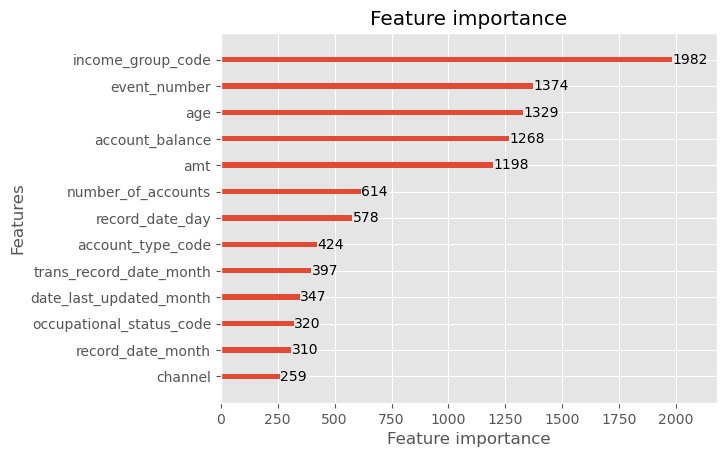

In [27]:
plot_importance(model)

In [28]:
# [(name, imp) for name , imp in zip(lgbm_full.feature_name_, lgbm_full.feature_importances_)]

In [29]:
create_sub_file(test["customer_identifier"], preds, "lgbm_base")

In [30]:
import lightgbm as lgb
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

# load your data and split it into train and test sets

# define the hyperparameter space for LightGBM
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": sp_randint(200, 5_000),
    "num_leaves": sp_randint(6, 50),
    "min_child_samples": sp_randint(50, 200),
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    "reg_alpha": [0, 0.1, 0.5, 1, 10],
    "reg_lambda": [0, 0.1, 0.5, 1, 10],
}

# create the LightGBM model and the random search object
lgb_model = lgb.LGBMRegressor()
random_search = RandomizedSearchCV(
    lgb_model,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring="neg_mean_squared_error",
)

# fit the random search object to the training data
random_search.fit(X_train, y_train)

# print the best hyperparameters and the corresponding score
print("Best parameters:", random_search.best_params_)
print("Best score:", -1 * random_search.best_score_)

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_samples': 52, 'n_estimators': 360, 'num_leaves': 41, 'reg_alpha': 10, 'reg_lambda': 1, 'subsample': 1.0}
Best score: 5353851.768191274
